In [4]:
import warnings

import cv2
from sklearn.utils import validation
import keras
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [5]:
from keras import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, LeakyReLU
from keras.layers import BatchNormalization, Activation, Conv2D 
from keras.layers import GlobalAveragePooling2D, Lambda
from keras.optimizers import Adam, RMSprop

In [6]:
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

In [7]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from utils.read_images import read_images

## Write a function to load in the data

In [8]:
def load_data(img_shape=(299, 299)):
    ids_and_genres = pd.read_csv("data/posters-and-genres.csv")
    ids_and_genres.drop(['Genre'], axis=1, inplace=True) # genre is irrelevant with boolean encoded genres

    ids = ids_and_genres['Id'].values[:1000]
    genres = ids_and_genres.loc[:, ids_and_genres.columns != 'Id'].values[:1000]

    # info = dict()
    # for i, id in enumerate(ids):
    #     info[id] = genres[i]

    imgs = read_images(ids)
    
    x_train, x_test, y_train, y_test = train_test_split(imgs, genres, test_size=0.2)
    
    return x_train, x_test, y_train, y_test

## Just a bunch of helper functions that I may not use

In [9]:
def generalized_mean_pool_2d(X, gm_exp=tf.Variable(3., dtype=tf.float32)):
    pool = (tf.reduce_mean(tf.abs(X**(gm_exp)), 
                           axis=[1,2], 
                           keepdims=False)+1.e-8)**(1./gm_exp)
    return pool

def batch_GAP(y_t, y_p):
    pred_cat = tf.argmax(y_p, axis=-1)    
    y_t_cat = tf.argmax(y_t, axis=-1) * tf.cast(
        tf.reduce_sum(y_t, axis=-1), tf.int64)
    
    n_pred = tf.shape(pred_cat)[0]
    is_c = tf.cast(tf.equal(pred_cat, y_t_cat), tf.float32)

    GAP = tf.reduce_mean(
          tf.cumsum(is_c) * is_c / tf.cast(
              tf.range(1, n_pred + 1), 
              dtype=tf.float32))
    
    return GAP    

def binary_crossentropy_n_cat(y_t, y_p):
    return keras.metrics.binary_crossentropy(y_t, y_p) * 25 # n_cat


## Function display results

In [10]:
# This function plots history of model training
import os

def plot_history(result):
    # Create and save a plot consists of val_loss and val_acc
    fig = plt.figure()

#     loss = fig.add_subplot(1, 1, 1)
    plt.plot(result.history['val_loss'], label='val_loss')
    plt.xlabel("Epcohs")
    plt.ylabel("Loss")
    plt.savefig(os.path.join(os.getcwd(), 'Data', 'loss.png'))
#     acc = fig.add_subplot(2, 1, 1)
    fig = plt.figure()
    plt.plot(result.history['val_accuracy'], label='val_accuracy')
    plt.xlabel("Epcohs")
    plt.ylabel("Accuracy")
    
    plt.savefig(os.path.join(os.getcwd(), 'Data', 'accuracy.png'))

## Train function 

In [9]:
def train(model):
    print("Loading data..........", end="")
    x_train, x_test, y_train, y_test = load_data()
    print("DONE")
    print("SHAPES:")
    print("xtrain:", x_train.shape)
    print("ytrain:", y_train.shape)
    
    checkpoint1 = ModelCheckpoint('xception_checkpoint-1.h5',
                              save_freq='epoch',
                              verbose=1,
                              save_weights_only=True)
    checkpoint2 = ModelCheckpoint('xception_checkpoint-2.h5',
                                save_freq='epoch',
                                verbose=1, 
                                save_weights_only=True)
    checkpoint3 = ModelCheckpoint('xception_checkpoint-3-best.h5',
                                save_freq='epoch',
                                verbose=1, 
                                monitor='loss', 
                                save_best_only=True, 
                                save_weights_only=True)
    print("Checkpoints set.")
    
    print("Fit model on training data")
    result = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), \
        callbacks=[checkpoint1, checkpoint2, checkpoint3])
    
    # Plot history
    plot_history(result)

## main function

In [10]:


def main():
    # K.clear_sessions()
    n_cat = 25
    label_encoder = LabelEncoder()
    one_hot_encoder = OneHotEncoder(sparse=True)
    input_shape = (299, 299)
    num_channels = 3

    model = Xception(input_shape=list(input_shape) + [num_channels], weights="imagenet", include_top=False)
    # model.summary()
    for layer in model.layers:
        layer.trainable = True
    for layer in model.layers[:85]:
        layer.trainable = False
    
#     print(model.summary())
    gm_exp = tf.Variable(3., dtype=tf.float32)
    x_feat = Input(model.output_shape[1:])

    lambda_layer = Lambda(generalized_mean_pool_2d)
    lambda_layer.trainable_weights.extend([gm_exp])
    X = lambda_layer(x_feat)
    X = Dropout(0.05)(X)
    X = Activation('relu')(X)
    X = Dense(n_cat, activation='softmax')(X)

    top_model = Model(inputs=x_feat, outputs=X)
#     print(top_model.summary())
    x_image = Input(list(input_shape) + [3])

    x_f = model(x_image)
    x_f = top_model(x_f)
    model = Model(inputs=x_image, outputs=x_f)
#     print(model.summary())
    model.load_weights("xception_checkpoint-3-best.h5")
    optimizer = Adam(lr=0.0001)
    loss = tf.keras.losses.BinaryCrossentropy()
    model.compile(loss=loss, optimizer=optimizer, metrics=[binary_crossentropy_n_cat, 'accuracy', batch_GAP])
    train(model)

In [11]:
def another_main():
    print("Loading data..........", end="")
    x_train, x_test, y_train, y_test = load_data()
    print("DONE")
    
    model = Xception(input_shape=list(input_shape) + [num_channels], weights="imagenet", classes=len(y_train[0]))
    model = load_model
    optimizer = Adam(lr=0.0001)
    loss = tf.keras.losses.BinaryCrossentropy()
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    
    checkpoint1 = ModelCheckpoint('xception_checkpoint-1.h5',
                              save_freq='epoch',
                              verbose=1,
                              save_weights_only=True)
    checkpoint2 = ModelCheckpoint('xception_checkpoint-2.h5',
                                save_freq='epoch',
                                verbose=1, 
                                save_weights_only=True)
    checkpoint3 = ModelCheckpoint('xception_checkpoint-3-best.h5',
                                save_freq='epoch',
                                verbose=1, 
                                monitor='loss', 
                                save_best_only=True, 
                                save_weights_only=True)
    print("Checkpoints set.")
    
    print("Fit model on training data")
    result = model.fit(x_train, y_train, epochs=200, validation_data=(x_test, y_test), \
        callbacks=[checkpoint1, checkpoint2, checkpoint3])
    
    # Plot history
    plot_history(result)

In [12]:
main()

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=() dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
Loading data..........

KeyboardInterrupt: 

In [11]:
# This function finds the threshold for predicting
def load_model(weights_path):
    
    n_cat = 25
    label_encoder = LabelEncoder()
    one_hot_encoder = OneHotEncoder(sparse=True)
    input_shape = (299, 299)
    num_channels = 3

    model = Xception(input_shape=list(input_shape) + [num_channels], weights="imagenet", include_top=False)
    # model.summary()
    for layer in model.layers:
        layer.trainable = True
    for layer in model.layers[:85]:
        layer.trainable = False
    
#     print(model.summary())
    gm_exp = tf.Variable(3., dtype=tf.float32)
    x_feat = Input(model.output_shape[1:])

    lambda_layer = Lambda(generalized_mean_pool_2d)
    lambda_layer.trainable_weights.extend([gm_exp])
    X = lambda_layer(x_feat)
    X = Dropout(0.05)(X)
    X = Activation('relu')(X)
    X = Dense(n_cat, activation='softmax')(X)

    top_model = Model(inputs=x_feat, outputs=X)
#     print(top_model.summary())
    x_image = Input(list(input_shape) + [3])

    x_f = model(x_image)
    x_f = top_model(x_f)
    model = Model(inputs=x_image, outputs=x_f)
#     print(model.summary())
    model.load_weights(weights_path)
    return model

def find_threshold():
    model = load_model("xception_checkpoint-3-best.h5")  # Load model
    print("Loading data.......", end="")
    x_train, x_test, y_train, y_test = load_data()  # Load data
    print("done")
    data = np.concatenate((x_train, x_test), axis=0)
    label = np.concatenate((y_train, y_test), axis=0)
    thresholds = [0.9, 0.8, 0.7, 0.6, 0.5]
    plot_data = []
    predictions = []

    for threshold in thresholds:
        evaluation = evaluate(model, threshold, data, label, 25)
        plot_data.append(evaluation[0])
        predictions.append(evaluation[1])

    fig = plt.figure()
    plt.plot(thresholds, plot_data, color='red')
    plt.title("Model Accuracy per Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("Model Prediction Performance")
    plt.savefig(os.path.join('xceptionnet-evaluation.png'))
    plt.show()
    
    fig = plt.figure()
    plt.bar(np.arange(len(thresholds)), [x - 0.9 for x in plot_data], bottom=0.9, align='center', color='orange')
    plt.title("Model Accuracy per Threshold")
    plt.xticks(np.arange(len(thresholds)), thresholds)
    plt.xlabel("Threshold")
    plt.ylabel("Model Prediction Performance")
    plt.savefig(os.path.join('xceptionnet-evaluation-bar.png'))
    plt.show()
    
    return {
        "thresholds": thresholds,
        "plot_data": plot_data,
        "data": data,
        "labels": label,
        "predictions": predictions
    }

# This function evaluates the model performance given the threshold and other data
def evaluate(model, threshold, data, label, num_genres):
    print("Predicting.......", end="")
    prediction = model.predict(data)
    print("done")
    acc = 0

    for result, sub_label in zip(prediction, label):
        for i in range(num_genres):
            if result[i] >= threshold and sub_label[i] == 1:
                acc += 1

            if result[i] < threshold and sub_label[i] == 0:
                acc += 1

    return (acc / (len(label) * num_genres), prediction)

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=() dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
Loading data.......done
Predicting.......done
Predicting.......done
Predicting.......done
Predicting.......done
Predicting.......done


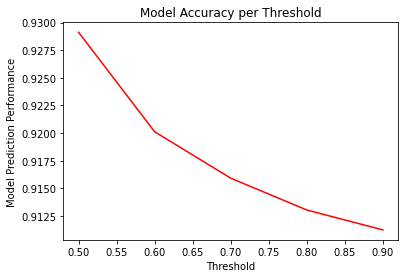

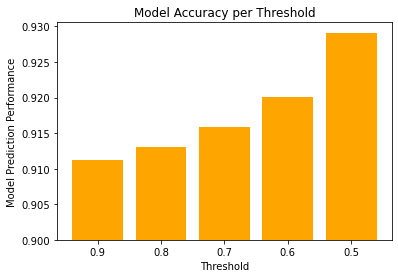

In [12]:
results = find_threshold()

In [ ]:
print(results["plot_data"])

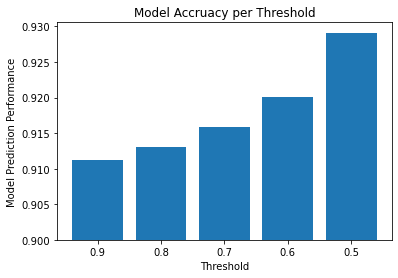

In [34]:
fig = plt.figure()
plt.bar(np.arange(len(results["thresholds"])), [x - 0.9 for x in results["plot_data"]], bottom=0.9, align='center')
plt.title("Model Accuracy per Threshold")
plt.xticks(np.arange(len(results["thresholds"])), results["thresholds"])
plt.xlabel("Threshold")
plt.ylabel("Model Prediction Performance")
# plt.savefig(os.path.join('xceptionnet-evaluation-bar.png'))
plt.show()

In [26]:
# show what is being predicted (the output of the network)
predictions_threshold_90 = results['predictions'][0]
for i in range(len(results['labels'])):
    print("===============================================================================================================")
    print("PRED:", " ".join([str(round(x, 1)) for x in predictions_threshold_90[i]]))
    print("REAL:", " ".join([str(x) for x in results['labels'][i].astype(float)]))

PRED: 0.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.3 0.0 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
REAL: 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
PRED: 0.0 0.0 0.0 0.0 0.7 0.2 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
REAL: 0.0 0.0 0.0 0.0 1.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
PRED: 0.0 0.0 0.0 0.0 0.7 0.1 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
REAL: 0.0 0.0 0.0 0.0 1.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
PRED: 0.0 0.0 0.0 0.0 0.0 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.4 0.0 0.0
REAL: 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0
PRED: 0.0 0.0 0.0 0.0 0.5 0.0 0.0 0.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
REAL: 0.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 

REAL: 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
PRED: 0.0 0.0 0.0 0.0 0.0 0.4 0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.4 0.0 0.0 0.0 0.0 0.0 0.0
REAL: 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0
PRED: 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.5 0.0 0.0 0.0 0.0 0.0
REAL: 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0
PRED: 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
REAL: 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
PRED: 0.0 0.0 0.0 0.0 0.7 0.0 0.0 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
REAL: 0.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
PRED: 0.4 0.4 0.0 0.0 0.0 0.0 0.0 0.2 0.0 0.0 

REAL: 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
PRED: 0.0 0.0 0.0 0.0 0.6 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.1 0.0 0.0
REAL: 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0
PRED: 0.0 0.3 0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
REAL: 0.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
PRED: 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
REAL: 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
PRED: 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.4 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.4 0.0 0.0
REAL: 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0
PRED: 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 

PRED: 0.3 0.0 0.0 0.0 0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.0
REAL: 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0
PRED: 0.0 0.0 0.0 0.0 0.2 0.0 0.0 0.7 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
REAL: 0.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
PRED: 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.6 0.0 0.0
REAL: 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0
PRED: 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
REAL: 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
PRED: 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
REAL: 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 